In [1]:
%load_ext autoreload
%autoreload 2

import os
import respy as rp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from random import randrange

from collections import OrderedDict
from collections import defaultdict

import respy as rp
#from respy.pre_processing.model_processing import process_params_and_options

from python.auxiliary import *

# Simulated Method of Moments estimation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-&amp;-Observed-Data" data-toc-modified-id="Model-&amp;-Observed-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model &amp; Observed Data</a></span></li><li><span><a href="#Setup-for-SMM-Estimation" data-toc-modified-id="Setup-for-SMM-Estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup for SMM Estimation</a></span><ul class="toc-item"><li><span><a href="#Calculate-Moments" data-toc-modified-id="Calculate-Moments-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate Moments</a></span><ul class="toc-item"><li><span><a href="#Function-for-calculating-moments" data-toc-modified-id="Function-for-calculating-moments-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Function for calculating moments</a></span></li><li><span><a href="#Observed-Moments" data-toc-modified-id="Observed-Moments-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Observed Moments</a></span></li></ul></li><li><span><a href="#Weighting-Matrix" data-toc-modified-id="Weighting-Matrix-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Weighting-Matrix</a></span></li><li><span><a href="#Criterion-Function" data-toc-modified-id="Criterion-Function-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Criterion Function</a></span></li></ul></li><li><span><a href="#SMM-Estimation" data-toc-modified-id="SMM-Estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SMM Estimation</a></span><ul class="toc-item"><li><span><a href="#Define-starting-paramters" data-toc-modified-id="Define-starting-paramters-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define starting paramters</a></span></li><li><span><a href="#Simulated-Moments" data-toc-modified-id="Simulated-Moments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Simulated Moments</a></span></li><li><span><a href="#Optimization-proceidure" data-toc-modified-id="Optimization-proceidure-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Optimization proceidure</a></span><ul class="toc-item"><li><span><a href="#Upper-and-Lower-Bounds" data-toc-modified-id="Upper-and-Lower-Bounds-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Upper and Lower Bounds</a></span></li><li><span><a href="#Constraints" data-toc-modified-id="Constraints-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Constraints</a></span></li><li><span><a href="#Optimize" data-toc-modified-id="Optimize-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Optimize</a></span></li><li><span><a href="#Plot-Criterion-Function" data-toc-modified-id="Plot-Criterion-Function-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Plot Criterion Function</a></span></li></ul></li></ul></li><li><span><a href="#Simulation-Study" data-toc-modified-id="Simulation-Study-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation Study</a></span><ul class="toc-item"><li><span><a href="#Changing-the-Simulation-Seed" data-toc-modified-id="Changing-the-Simulation-Seed-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Changing the Simulation Seed</a></span></li></ul></li></ul></div>

**To do:**
   - Part 4
   - Add text and descriptions to all sections of the notebook
   - Implement algorithm for calculating the weighting matrix

##  Observed Data

Our model and data is given by [respy](https://respy.readthedocs.io/en/latest/)'s `robinson` example model. In this simple model, the agent, Robinson Crusoe, in each time period decides between two choice options: working (i.e. going fishing) or spending time in the hammock. We use the function `get_example_model `to simulate the model and a dataset.

For the remainder of this notebook we will treat these observations as though they are real observed data and try to recover the parameters of the model using this data. However, since this is actually a simulated model for which we know the true parameter vector, we will be able to compare how well our estimation procedures perform.

In [2]:
params_true, options, data_obs = rp.get_example_model("robinson", with_data=True)

Uncomment the lines of code below to take a look at the model specifications and observed data.

In [3]:
# params_true 

In [4]:
# options

In [5]:
# data_obs.head(10)

## Data Moments

For the setup of the estimation we first have to choose a set of moments that we will use to match the observed data and the simulated model. For this model we include two sets of moments: 

1. The first set are Robinson's choice probabilities (choice probabilities here refers to the share of agents that have chosen a specific option) for each period. 
2. The second set are moments that characterize the wage distribution for each period, i.e. the mean of the wage of all agents that have chosen fishing in a given period and the standard deviation of the wages. 

In [6]:
# Specify the potential choice options.
choice_options_robinson = ['fishing', 'hammock']

In [7]:
# Use a function to calculate the data moments.
moments_obs = get_moments(data_obs, choice_options_robinson)
print('Choice Probabilities')
print(moments_obs['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_obs['Wage Distribution'])

Choice Probabilities
{0: [0.631, 0.369], 1: [0.631, 0.369], 2: [0.631, 0.369], 3: [0.631, 0.369], 4: [0.631, 0.369]}

 Wage Distribution
{0: [1.0037950532864608, 0.009222735533113452], 1: [1.0724623646069125, 0.010885774459361966], 2: [1.1506433910875764, 0.01165976621540699], 3: [1.2325871778674606, 0.01188724268886421], 4: [1.3230636324871103, 0.012512007111785479]}


## Weighting-Matrix

Next we specify a weighting matrix.

In [8]:
# I use the identity matrix for now.
num_moments = options['n_periods']*len(choice_options_robinson)*2
identity_matrix = np.eye(num_moments)
print(identity_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

## Criterion Function 

Criterion function at the true parameter vector.

In [9]:
fval = evaluate(params_true, options, identity_matrix, moments_obs, choice_options_robinson)
fval

0.0

We can plot the criterion function to examine its behavior around the minimum in more detail. The plots below show the criterion function at varying values of the parameter for delta. Each plot depicts the criterion function for a progressively smaller range to 'zoom in' on the true minimum value of 0.95 given by the true parameter vector. 

Criterion function for varying values of delta:

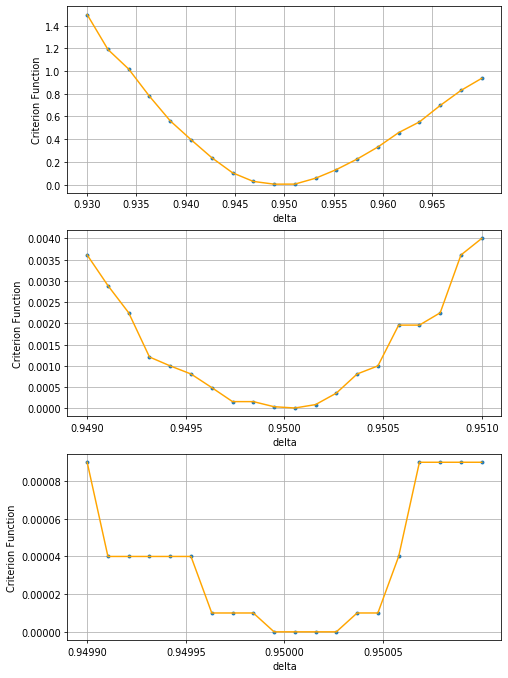

In [10]:
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_fun(params_true, 
                   'delta', 
                   [0.93, 0.949, 0.9499], # lower bound
                   [0.97, 0.951, 0.9501], # upper bound
                   [0.005,0.0005, 0.00005], # xticks steps
                   20, # number of parameter values calculated (blue dots)
                   criterion_args) 


In [11]:
"""
# Criterion function for varying values of the wage_fishing
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_fun(params_true, 
                   'wage_fishing', 
                   [0.068, 0.06999, 0.0699999], # lower bound
                   [0.074, 0.07001, 0.0700001], # upper bound
                   [0.0005, 0.000005, 0.00000005], # xticks steps
                   30, # number of parameter values calculated (blue dots)
                   criterion_args) """

"\n# Criterion function for varying values of the wage_fishing\ncriterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]\nplot_criterion_fun(params_true, \n                   'wage_fishing', \n                   [0.068, 0.06999, 0.0699999], # lower bound\n                   [0.074, 0.07001, 0.0700001], # upper bound\n                   [0.0005, 0.000005, 0.00000005], # xticks steps\n                   30, # number of parameter values calculated (blue dots)\n                   criterion_args) "

##  Estimation

### Define starting parameters


Let's assume now that we do not know the true parameter vector and we seek to estimate it using our observed data. We have already set up the criterion function and the weighting matrix. In the following we will first select parameter vector that differs from the true one as a candidate to begin the estimation with. We will then specify an optimization procedure for our criterion function to try to retrieve the true parameters. 

For now, our candidate parameter vector will just differ in *delta* from the true parameters.

In [12]:
# Define candidate parameters: For now we just change one parameter
params_cand = params_true.copy()
params_cand.loc['delta','value'] = 0.93

### Simulated Moments

We can now use our model to simulate data using the candidate parameter vector. We can see that the choice probabilities and wage distribution differ from the moments of the observed dataset.

In [13]:
params = params_cand.copy()
simulate = rp.get_simulate_func(params, options)
df_sim = simulate(params)
moments_sim = get_moments(df_sim, choice_options_robinson)

print('Choice Probabilities')
print(moments_sim['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_sim['Wage Distribution'])

Choice Probabilities
{0: [0.244, 0.756], 1: [0.244, 0.756], 2: [0.244, 0.756], 3: [0.244, 0.756], 4: [0.244, 0.756]}

 Wage Distribution
{0: [1.0095149927160547, 0.008198290003548022], 1: [1.0728957195893678, 0.010514385733230281], 2: [1.1515521441487266, 0.011934344072283899], 3: [1.2330302273612044, 0.011737002476584076], 4: [1.3217938871844948, 0.013266040322672396]}


We can see that the criterion function value for the candidate parameter vector is not zero.

In [14]:
fval = evaluate(params_cand, options, identity_matrix, moments_obs, choice_options_robinson)
fval

1.4977273938311657

### Optimization procedure

We will now use an optimization procedure to retrieve the true parameter vector. For the optimization I use [estimagic](https://estimagic.readthedocs.io/en/latest/index.html). Estimagic is a Python package that is developed to help implement (structural) econometric models and offers a variety of customization options for the optimization procedure as well as a large selection of algorithms.

We have verified above that the criterion function gives a value of 0 for the true parameter vector. Before we try different parameter specifications, we can check whether an optimizer recognizes the true vector as the minimum of our criterion function.

For our optimization procedure we need estimagic's `minimize` function.

In [15]:
from estimagic.optimization.optimize import minimize

As inputs for the `minimize` function we need to specify:
* the the criterion function we want to minimize
* the parameter vector with respect to which we want to minimize the criterion function
* one of the optimization [algorithms that estimagic supports](https://estimagic.readthedocs.io/en/latest/optimization/algorithms.html)
* possible other arguments of the criterion function (e.g. the weighting matrix or moments)

As the code below shows, the optimization algorithm recognizes the true parameter vector as the minimum of the criterion function as it returns a function value of 0 and the true parameter values.

In [16]:
rslt = minimize(criterion=evaluate,
                params=params_true,
                algorithm="nlopt_bobyqa",
                criterion_args=(options, identity_matrix, moments_obs, choice_options_robinson),
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.95, 0.07, -0.1, 1.046, 0.01, 0.01, 0.0]}

#### Upper and Lower Bounds

We can help the optimizer by specifying bounds for the parameters. Since we know the true parameters in the case of this model, the bounds are easy to specify. We just pick upper and lower bounds that are fairly close to the true values of the parameters to aid the optimizer in the search for the optimum. 

By default, the upper and lower bounds are set to $\infty$ and $-\infty$, so specifying upper and lower bounds substantially reduces the range of parameter values that the optimizer can potentially cover. Even if the true parameters are unknown, the model usually imposes certain restrictions and assumptions on the parameters that allows us to rule out many potential parameter values. For example, we can assume that the non-pecuniary value of fishing is negative because working is strenuous and thus causes Robinson disutility in our model of interest.

For optimization with estimagic, we can specify bounds by adding the columns *'lower'* and *'upper'* to the dataframe that contains the parameter values.

In [17]:
# Lower and upper bound for parameters
params_cand['lower'] = [0.89, 0.066, -0.11, 1.04, -0.1, 0.1, 0]
params_cand['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]
params_cand

value  lower  upper
category       name                                     
delta          delta                 0.930  0.890  0.980
wage_fishing   exp_fishing           0.070  0.066  0.072
nonpec_fishing constant             -0.100 -0.110 -0.095
nonpec_hammock constant              1.046  1.040  1.055
shocks_sdcorr  sd_fishing            0.010 -0.100  0.100
               sd_hammock            0.010  0.100  0.100
               corr_hammock_fishing  0.000  0.000  0.100

#### Constraints
In addition to specifying bounds, [estimagic allows us to specify constraints](https://estimagic.readthedocs.io/en/latest/optimization/constraints/index.html) for the optimization procedure. As shown below, we can specify that the the parameters in the category *shocks_sdcorr* are standard deviations and correlations and we can also hold some parameters in our vector fixed for the optimization. 

In [18]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

#### Optimize

In [19]:
rslt = minimize(criterion=evaluate,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                # dashboard=True # <-- uncommenting this code will launch a dashboard when this cell is run 
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.950025]}

## Simulation Alterations

### Changing multiple parameters

In [20]:
params_multi = params_true.copy()
params_multi.loc['delta', 'value'] = 0.96
params_multi.loc['wage_fishing'] = 0.0705
params_multi.loc[('nonpec_fishing','value')] = -0.095
params_multi.loc[('nonpec_hammock','value')] = 1.05
params_multi.loc[("shocks_sdcorr","sd_fishing"),"value"] = 0.01
params_multi.loc[("shocks_sdcorr","sd_hammock"),"value"] = 0.01
params_multi.loc[("shocks_sdcorr","corr_hammock_fishing"), "value"] = 0

In [21]:
simulate = rp.get_simulate_func(params_multi, options)
data_sim = simulate(params_multi)
data_sim.Choice.value_counts()

fishing    4755
hammock     245
Name: Choice, dtype: int64

In [22]:
params_multi['lower'] = [0.89, 0.066, -0.11, 1.04, 0, 0, 0]
params_multi['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]

In [23]:
params_multi

value  lower  upper
category       name                                      
delta          delta                 0.9600  0.890  0.980
wage_fishing   exp_fishing           0.0705  0.066  0.072
nonpec_fishing constant             -0.0950 -0.110 -0.095
nonpec_hammock constant              1.0500  1.040  1.055
shocks_sdcorr  sd_fishing            0.0100  0.000  0.100
               sd_hammock            0.0100  0.000  0.100
               corr_hammock_fishing  0.0000  0.000  0.100

In [24]:
constr_free_multi = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    #{"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    #{"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

rslt_multi = minimize(criterion=evaluate,
                params=params_multi,
                algorithm="nlopt_bobyqa",
                constraints=constr_free_multi,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                dashboard=True
               )
rslt_multi[0]

{'fun': 1.5315769746670102e-05,
 'internal_x': [0.9591929959549406,
  0.07056355154746428,
  -0.09870515344708546,
  1.0501810814176873]}

In [25]:
rslt_multi[1]

value  lower  upper           group  \
category       name                                                           
delta          delta                 0.959193  0.890  0.980  All Parameters   
wage_fishing   exp_fishing           0.070564  0.066  0.072  All Parameters   
nonpec_fishing constant             -0.098705 -0.110 -0.095  All Parameters   
nonpec_hammock constant              1.050181  1.040  1.055  All Parameters   
shocks_sdcorr  sd_fishing            0.010000  0.000  0.100  All Parameters   
               sd_hammock            0.010000  0.000  0.100  All Parameters   
               corr_hammock_fishing  0.000000  0.000  0.100  All Parameters   

                                                                   name  \
category       name                                                       
delta          delta                                        delta_delta   
wage_fishing   exp_fishing                     wage_fishing_exp_fishing   
nonpec_fishing constant                         nonpec_fishing_constant   
nonpec_hammock constant                         nonpec_hammock_constant   
shocks_sdcorr  sd_fishing                      shocks_sdcorr_sd_fishing   
               sd_hammock                      shocks_sdcorr_sd_hammock   
               corr_hammock_fishing  shocks_sdcorr_corr_hammock_fishing   

                                     _fixed  
category       name                          
delta          delta                  False  
wage_fishing   exp_fishing            False  
nonpec_fishing constant               False  
nonpec_hammock constant               False  
shocks_sdcorr  sd_fishing              True  
               sd_hammock              True  
               corr_hammock_fishing    True

### Changing the Simulation Seed

During estimation, the optimizer in each iteration evaluates the criterion function for a new set of parameter values and checks, whether this set of parameters results in a smaller value of the criterion. It is important to ensure, that the parameter values are the only part of the model specification that changes with each iteration, as the optimizer can otherwise not effectively assess the criterion function for changing parameter values. 

For estimation using the simulated method of moments approach, it is thus essential that the random elements drawn during simulation stay the same for the entire estimation procedure. Respy automatically controls randomness in the simulation via the *simulation seed* specified in the model `options`. The simulation seed ensures that simulating data with respy always returns the same dataset.

The function shown below allows for a change in the simulation seed at each iteration during optimization. When the argument *change_seed* is set to <span style="color:green">**True**</span>, the function chooses a random simulation seed each time it is called, thus drawing new data for every iteration.

In [26]:
def crit_func_rand_seed(params_cand, options, weighting_matrix, moments_obs, choice_options, max_iter, change_seed=False):
    options = options.copy()
    i = 0
    # Change simulation seed at each function call if change_seed == True.
    if change_seed:
        options["simulation_seed"] = randrange(500,999)
        fval = evaluate(params_cand, options, weighting_matrix, moments_obs, choice_options)
    # Keep same simulation seed if change_seed == False.
    else:
        fval = evaluate(params_cand, options, weighting_matrix, moments_obs, choice_options)   
    i =+ 1
    # Stop evaluation if function reaches a maximum number of iterations.
    if i == max_iter:        
        fval = 99999
        
    return fval    

As the results below shows, changing the simulation seed prevents the criterion function from reaching a value of 0.

In [27]:
rslt_change_seed_off = minimize(criterion=crit_func_rand_seed,
                                params=params_cand,
                                algorithm="nlopt_bobyqa",
                                constraints=constr,
                                criterion_args=(options, identity_matrix, moments_obs, choice_options_robinson, 1000, 
                                                False),
                                )

rslt_change_seed_on  = minimize(criterion=crit_func_rand_seed,
                                params=params_cand,
                                algorithm="nlopt_bobyqa",
                                constraints=constr,
                                criterion_args=(options, identity_matrix, moments_obs, choice_options_robinson, 1000, 
                                                True),
                                )
print("Result for simulation with same seed:",rslt_change_seed_off[0])
print("Result for simulation with changing seeds:",rslt_change_seed_on[0])

Result for simulation with same seed: {'fun': 0.0, 'internal_x': [0.950025]}
Result for simulation with changing seeds: {'fun': 1.4657172891373573e-05, 'internal_x': [0.9495334490051308]}


#### Increasing the Number of Agents

Increasing the number of agents i.e. the size of the simulated sample should decrease the problems caused by he changing simulation seed.

In [28]:
options_num_agents = options.copy()
options_num_agents['simulation_agents'] = 100
rslt_change_seed_on  = minimize(criterion=crit_func_rand_seed,
                                params=params_cand,
                                algorithm="nlopt_bobyqa",
                                constraints=constr,
                                criterion_args=(options_num_agents, identity_matrix, moments_obs, choice_options_robinson, 
                                                1000, True),
                               )
rslt_change_seed_on[0]

{'fun': 0.009634709373564095, 'internal_x': [0.9468205685935834]}

In [29]:
options_num_agents = options.copy()
options_num_agents['simulation_agents'] = 10000
rslt_change_seed_on  = minimize(criterion=crit_func_rand_seed,
                                params=params_cand,
                                algorithm="nlopt_bobyqa",
                                constraints=constr,
                                criterion_args=(options_num_agents, identity_matrix, moments_obs, choice_options_robinson, 
                                                1000, True),
                               )
rslt_change_seed_on[0]

{'fun': 0.0007421742363209038, 'internal_x': [0.9491309186263601]}

In [30]:
agents_grid = np.round(np.linspace(50, 5000, 20))
options_num_agents = options.copy()
fvals_agents_grid = []

for val in agents_grid:
    options_num_agents['simulation_agents'] = int(val)
    rslt_num_agents  = minimize(criterion=crit_func_rand_seed,
                                params=params_cand,
                                algorithm="nlopt_bobyqa",
                                constraints=constr,
                                criterion_args=(options_num_agents, identity_matrix, moments_obs, 
                                                choice_options_robinson, 1000, 
                                                True),
                               )
    
    fvals_agents_grid.append(rslt_num_agents[0]['fun'])

Text(0.5, 1.0, 'Function Value for increasing Number of Agents with changing Simulation Seeds')

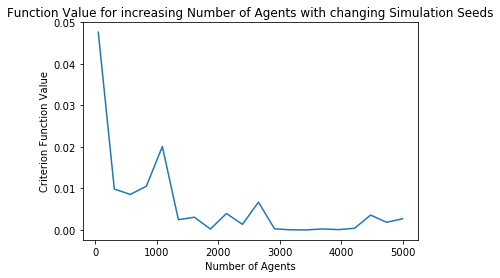

In [31]:
plt.plot(agents_grid, fvals_agents_grid)
plt.xlabel('Number of Agents')
plt.ylabel('Criterion Function Value')
plt.title('Function Value for increasing Number of Agents with changing Simulation Seeds')

---

In [32]:
#Changing Simulation Seed just once
options_new_seed = options.copy()
options_new_seed["simulation_seed"] = 222

rslt_new_seed = minimize(criterion=evaluate,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_args=(options_new_seed,identity_matrix, moments_obs, choice_options_robinson),
                    #dashboard=False
                    )
rslt_new_seed[0]

{'fun': 3.180262254405933e-06, 'internal_x': [0.9484047019406102]}

### Fixing one parameter at the wrong value

In [33]:
params_3 = params_true.copy()
params_3.loc["delta", "value"] = 0.97
params_3.loc["wage_fishing", "value"] = 0.069

params_3['lower'] = [0.89, 0.066, -0.11, 1.04, -0.1, 0.1, 0]
params_3['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]

In [34]:
# Hold all values except the changed parameter fixed 
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.069},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [35]:
simulate = rp.get_simulate_func(params_3, options)
data_sim = simulate(params_3)
data_sim.Choice.value_counts()

fishing    3780
hammock    1220
Name: Choice, dtype: int64

In [36]:
rslt_3 = minimize(criterion=evaluate,
                params=params_3,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                # dashboard=True # <-- uncommenting this code will launch a dashboard when this cell is run 
               )
rslt_3[0]

{'fun': 0.0010483936871990285, 'internal_x': [0.9635038359462313]}

### Retrieving the true parameter vector

In [37]:
params_4 = rslt_3[1][['value','lower','upper']]
params_4

value  lower  upper
category       name                                        
delta          delta                 0.963504  0.890  0.980
wage_fishing   exp_fishing           0.069000  0.066  0.072
nonpec_fishing constant             -0.100000 -0.110 -0.095
nonpec_hammock constant              1.046000  1.040  1.055
shocks_sdcorr  sd_fishing            0.010000 -0.100  0.100
               sd_hammock            0.010000  0.100  0.100
               corr_hammock_fishing  0.000000  0.000  0.100

In [38]:
# Hold all values except the changed parameter fixed 
constr_free_two = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [39]:
rslt_4 = minimize(criterion=evaluate,
                params=params_4,
                algorithm="nlopt_bobyqa",
                constraints=constr_free_two,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                # dashboard=True # <-- uncommenting this code will launch a dashboard when this cell is run 
               )
rslt_4[0]

{'fun': 5.181567551581337e-05,
 'internal_x': [0.9646885868785151, 0.0689605910448917]}

In [40]:
deviation = params_true['value'] - rslt_4[1]['value']
deviation

category        name                
delta           delta                  -0.014689
wage_fishing    exp_fishing             0.001039
nonpec_fishing  constant                0.000000
nonpec_hammock  constant                0.000000
shocks_sdcorr   sd_fishing              0.000000
                sd_hammock              0.000000
                corr_hammock_fishing    0.000000
Name: value, dtype: float64